# Importing all the required libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/superstore-data/superstore_dataset2011-2015.csv


# Uploading data

In [8]:
data = pd.read_csv('/kaggle/input/superstore-data/superstore_dataset2011-2015.csv', encoding='iso-8859-1')
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [9]:
data.shape

(51290, 24)

# Date time manipulation
Convert 'Order Date' to pandas Datatime format and split it into Order Month and Order Year columns. Cohort Year and Cohort Months are new columns with first year and month of order for that particular customer in the data set. Cohort index column has data about the first month when the customer made an order. Since some orders were made in different years and same months, it doesn't make logical sense to put those customers in the same cohort groups. 
> Cohort Index = (Order Year - Cohort Year) *  12 + (Order Month - Cohort Month) + 1

In [10]:
df = data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year
print(df['Order Year'].unique())
df['Cohort Month'] = df.groupby('Customer ID')['Order Date'].transform('min')
df['Cohort Month']  =df['Cohort Month'].dt.month
df['Cohort Year'] = df.groupby('Customer ID')['Order Date'].transform('min')
df['Cohort Year']  =df['Cohort Year'].dt.year
df['Cohort Index'] = (df['Order Year'] - df['Cohort Year']) * 12 + df['Order Month'] - df['Cohort Month'] + 1
df.drop(['Order Month', 'Order Year', 'Cohort Year'], axis = 1, inplace = True)
df.head()

[2011 2012 2013 2014]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Cohort Month,Cohort Index
0,42433,AG-2011-2040,2011-01-01,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium,1,1
1,22253,IN-2011-47883,2011-01-01,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium,1,1
2,48883,HU-2011-1220,2011-01-01,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High,1,1
3,11731,IT-2011-3647632,2011-01-01,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High,1,1
4,22255,IN-2011-47883,2011-01-01,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium,1,1


# Cohort data
Cohort data is grouped by Cohort Month and Cohort Index for customer count for each cohort month and index as can be seen below

In [11]:
cohort_data = df.groupby(['Cohort Month', 'Cohort Index'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot_table(index = 'Cohort Month', columns = 'Cohort Index', values = 'Customer ID')
cohort_size = cohort_count.iloc[:,0]
cust_retention = round(cohort_count.divide(cohort_size, axis = 0), 2)
cust_retention

Cohort Index,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Cohort Month,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.22,0.27,0.21,0.20,0.25,0.25,0.25,0.29,0.25,...,0.35,0.35,0.34,0.40,0.33,0.39,0.43,0.47,0.45,0.47
2,1.0,0.23,0.22,0.22,0.31,0.16,0.25,0.25,0.24,0.29,...,0.31,0.37,0.41,0.30,0.44,0.44,0.38,0.45,0.38,NaN
3,1.0,0.18,0.13,0.26,0.18,0.25,0.28,0.25,0.28,0.32,...,0.34,0.41,0.29,0.35,0.44,0.34,0.43,0.44,NaN,NaN
4,1.0,0.20,0.23,0.23,0.21,0.27,0.24,0.26,0.29,0.13,...,0.45,0.22,0.31,0.28,0.40,0.37,0.36,NaN,NaN,NaN
5,1.0,0.23,0.16,0.31,0.27,0.21,0.28,0.26,0.20,0.25,...,0.20,0.36,0.35,0.31,0.43,0.43,NaN,NaN,NaN,NaN
6,1.0,0.21,0.19,0.26,0.15,0.23,0.25,0.13,0.14,0.23,...,0.32,0.28,0.36,0.37,0.32,NaN,NaN,NaN,NaN,NaN
7,1.0,0.18,0.19,0.25,0.25,0.24,0.10,0.12,0.23,0.17,...,0.28,0.29,0.35,0.37,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.19,0.18,0.19,0.14,0.18,0.17,0.14,0.19,0.19,...,0.27,0.32,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.18,0.18,0.21,0.13,0.09,0.13,0.11,0.20,0.22,...,0.26,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cohort data vs Cohort Index heatmap

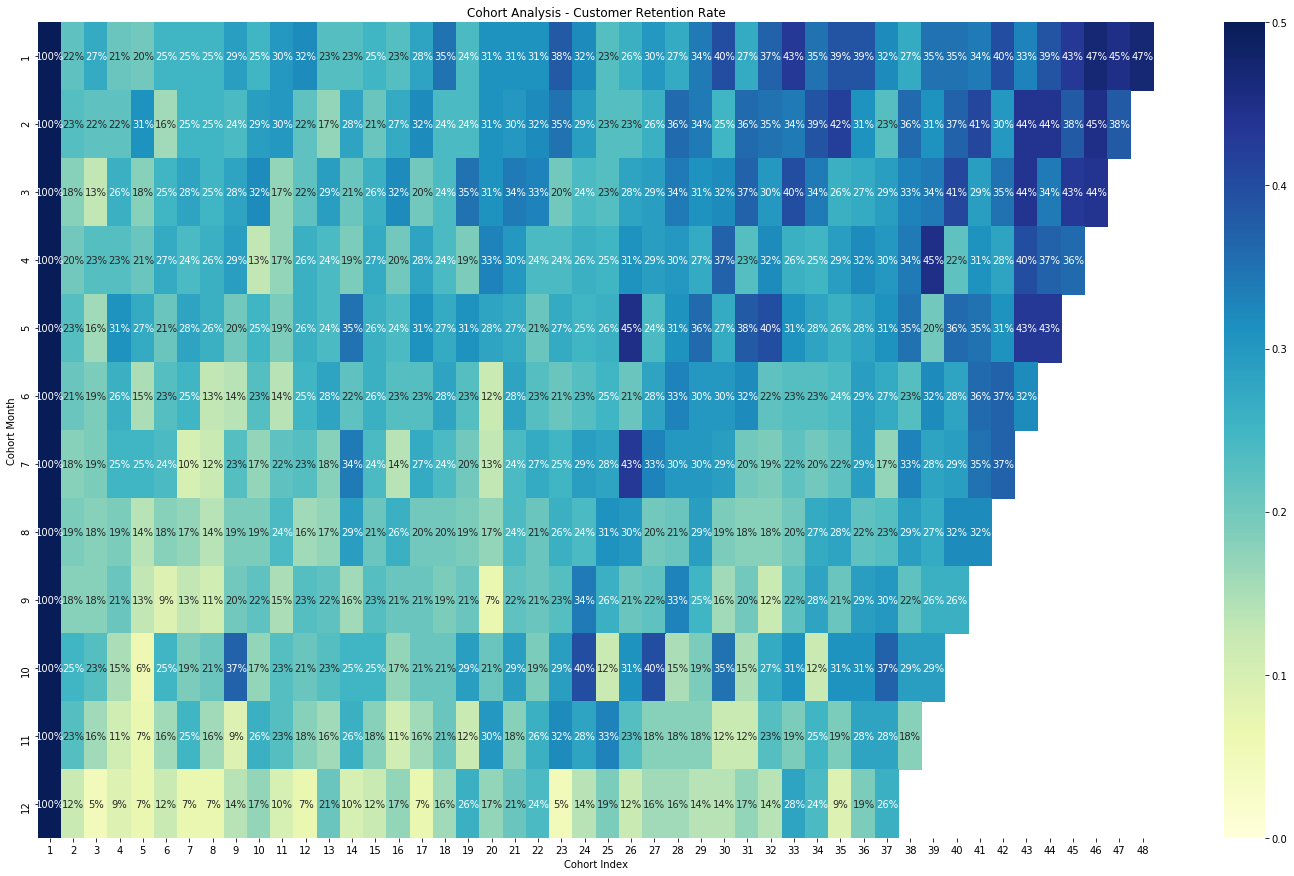

In [12]:
plt.figure(figsize = (25,15))
plt.title('Cohort Analysis - Customer Retention Rate')
sns.heatmap(cust_retention, annot = True, fmt = '.0%',vmin = 0.0,
            vmax = 0.5,cmap = "YlGnBu")

The above chart shows that most enrollments/first orders happened during the first half of the year. Enrollments/first orders that happen in the later half tend to taper down

# Cohort analysis - based on profit

## Converting profit into range using pandas cut method
Since profits are not discrete values, I chose to convert them into ranges by defining a set number of bins. Smaller bin sizes make it harder to understand difference in profits for different cohort groups. Therefore, I chose to use 5000 for bin numbers. 

In [13]:
df['Profit Range'] = pd.cut(df['Profit'], bins = 5000)
df['Profit Range'].head()

0    (105.001, 108.001]
1      (36.002, 39.002]
2      (27.002, 30.002]
3    (-26.998, -23.998]
4      (36.002, 39.002]
Name: Profit Range, dtype: category
Categories (5000, interval[float64]): [(-6614.978, -6596.978] < (-6596.978, -6593.978] < (-6593.978, -6590.978] < (-6590.978, -6587.978] ... (8387.976, 8390.976] < (8390.976, 8393.976] < (8393.976, 8396.976] < (8396.976, 8399.976]]

In [14]:
cohort_data = df.groupby(['Cohort Month', 'Cohort Index'])['Profit Range'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot_table(index = 'Cohort Month', columns = 'Cohort Index', values = 'Profit Range')
cohort_size = cohort_count.iloc[:,0]
cust_retention = round(cohort_count.divide(cohort_size, axis = 0), 2)
cust_retention

Cohort Index,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Cohort Month,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.51,0.41,0.36,0.41,0.52,0.43,0.57,0.50,0.50,...,0.61,0.71,0.64,0.71,0.61,0.77,0.68,0.81,0.84,0.81
2,1.0,0.40,0.45,0.40,0.50,0.30,0.39,0.43,0.43,0.40,...,0.56,0.52,0.56,0.48,0.80,0.65,0.49,0.65,0.58,NaN
3,1.0,0.35,0.31,0.47,0.35,0.43,0.53,0.46,0.47,0.62,...,0.55,0.71,0.53,0.61,0.74,0.65,0.66,0.88,NaN,NaN
4,1.0,0.36,0.60,0.43,0.43,0.55,0.44,0.44,0.59,0.32,...,0.65,0.38,0.66,0.65,0.62,0.72,0.63,NaN,NaN,NaN
5,1.0,0.34,0.50,0.57,0.41,0.48,0.51,0.49,0.39,0.45,...,0.49,0.74,0.68,0.70,0.88,0.70,NaN,NaN,NaN,NaN
6,1.0,0.46,0.40,0.55,0.33,0.48,0.66,0.31,0.28,0.46,...,0.64,0.60,0.70,0.73,0.67,NaN,NaN,NaN,NaN,NaN
7,1.0,0.33,0.33,0.66,0.46,0.39,0.21,0.26,0.51,0.31,...,0.56,0.49,0.71,0.67,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.42,0.35,0.32,0.46,0.35,0.38,0.31,0.44,0.56,...,0.86,0.67,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.27,0.47,0.40,0.36,0.24,0.30,0.30,0.51,0.37,...,0.59,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


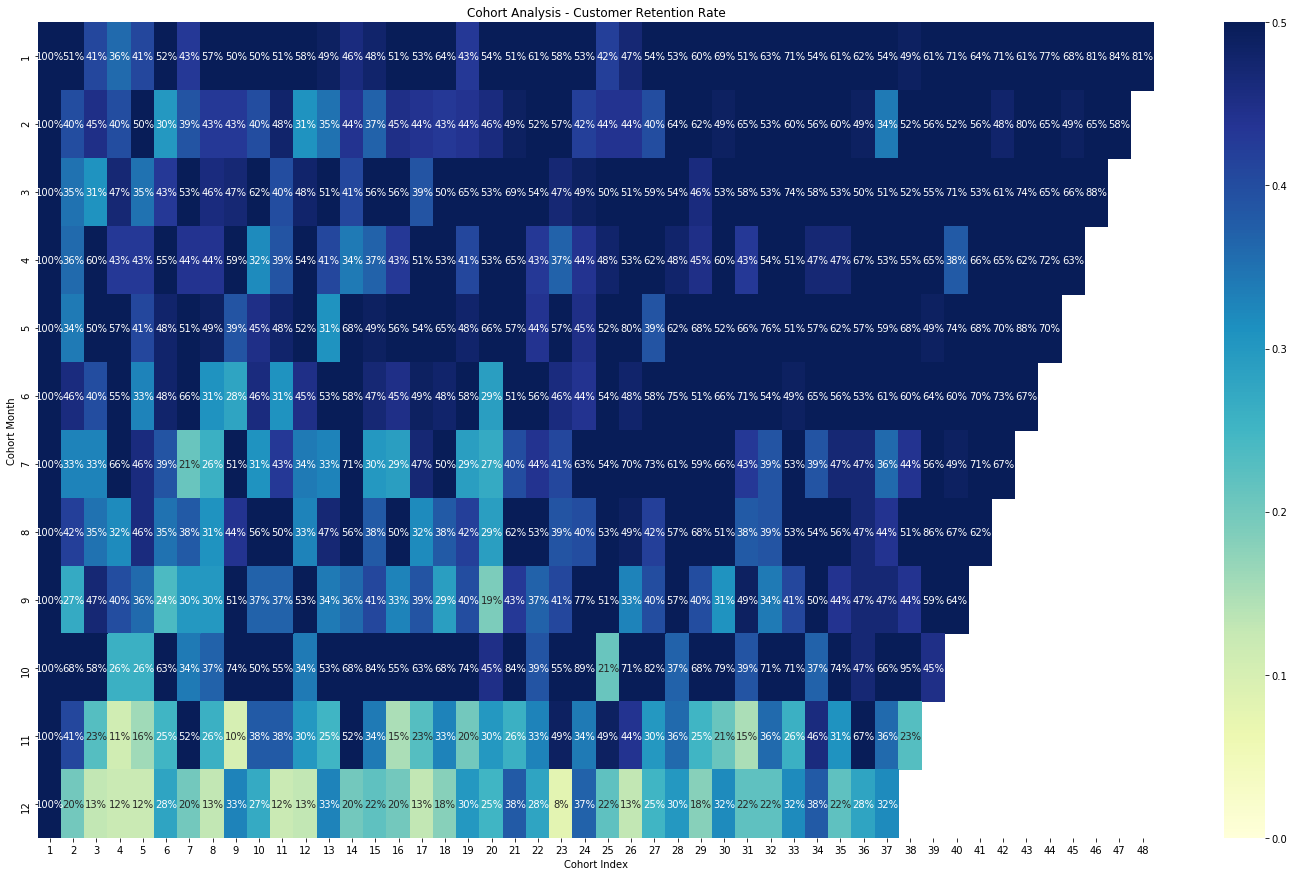

In [15]:
plt.figure(figsize = (25,15))
plt.title('Cohort Analysis - Customer Retention Rate')
sns.heatmap(cust_retention, annot = True, fmt = '.0%',vmin = 0.0,
            vmax = 0.5,cmap = "YlGnBu")

From the above chart we can conclude that people who register in the later half od the year are probably here to make one-time purchases.
Purchases during the 10 months of the year lead to most of the profits. 